In [1]:
import pandas as pd
import os
from fastai.vision.all import *
import math

C:\Users\bowan\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [13]:
Image_path = '/images_assorted'

if os.path.exists(Image_path):
    print("The file exists.")
else:
    %run Generating_basic_data.ipynb

In [ ]:
output_folder = 'Node1'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
output_folder = 'Node2'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
output_folder = 'Node3'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [2]:

df = pd.read_csv('image_data_assorted.csv')

In [3]:
df.head() # so you can see how its organised

,Radius,X_Position,Y_Position,Area,Surface2d,Volume,image_path,mask_path,shape
0,81,332,175,20602,254,2224966,images_assorted/image_1.png,masks_assorted/mask_1.png,circle
1,53,79,195,2809,212,148877,images_assorted/image_2.png,masks_assorted/mask_2.png,square
2,33,390,122,1089,132,35937,images_assorted/image_3.png,masks_assorted/mask_3.png,square
3,58,358,298,3364,232,195112,images_assorted/image_4.png,masks_assorted/mask_4.png,square
4,54,359,431,1458,184,157464,images_assorted/image_5.png,masks_assorted/mask_5.png,triange


In [4]:
def get_inputs(row):
    # Convert image path to PILImage
    image_path = row['image_path']
    image_data = PILImage.create(image_path)
    return image_data 

def get_target(row):
    # Convert image path to PILImage
    target_data = row['shape']
    return target_data

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Image input and auxiliary input
    get_x=get_inputs,  # Get both the image path and the auxiliary input
    get_y=get_target  # Get the radius value from the dataframe
    #splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Split into train and validation sets
    #item_tfms=Resize(512)  # Resize images to 512x512
)
#os.chdir('..') # just moves directory where shared dataset is
dls = dblock.dataloaders(df, bs=64)


torch.Size([64, 3, 512, 512])


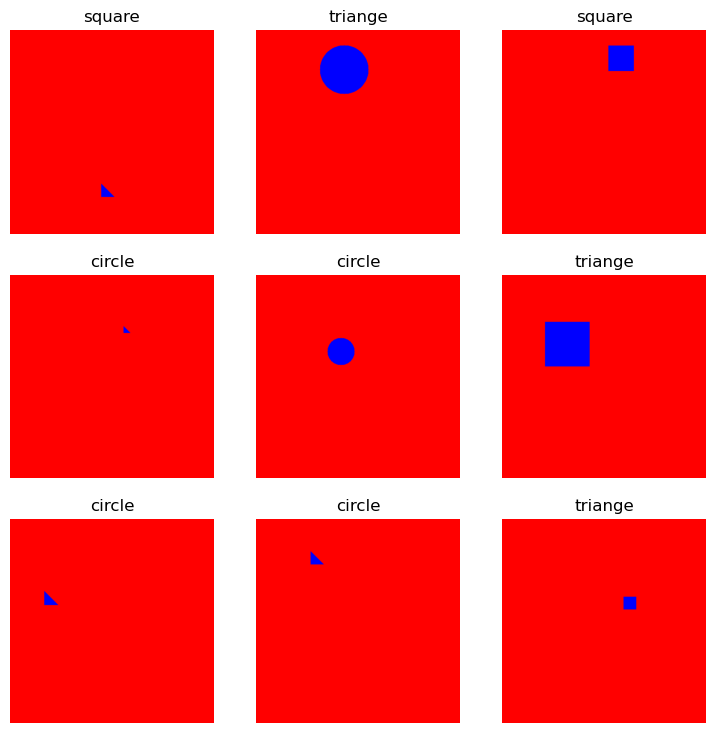

In [14]:
batch = dls.one_batch()
print(batch[0].shape)
dls.show_batch()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += identity
        x = F.relu(x)
        return x


class ResNet18Custom(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.in_channels = 64

        # Initial convolution and pooling
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = [BasicBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        # Residual blocks
        x = self.layer1(x)
        self.save_feature_map(x, "Node1/image_1.png")
        x = self.layer2(x)
        self.save_feature_map(x, "Node2/image_2.png")
        x = self.layer3(x)
        self.save_feature_map(x, "Node3/image_3.png")
        x = self.layer4(x)
        
        # Global Average Pooling and Fully Connected Layer
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def save_feature_map(self, x, save_path):
        # Detach, take mean of channels, normalize, and save
        #print(x.shape)
        x = x.detach().cpu().numpy()
        img = x[0].mean(axis=0)  # mean across channels
        x_min = img.min()
        x_max = img.max()
        img = (img - x_min) / (x_max - x_min) * 255
        img = img.astype("uint8")
        Image.fromarray(img).save(save_path)
        
        layers = x.shape
        layers = layers[1]
        i=0
        while i < layers : 
            img = x[0][i]
            x_min = img.min()
            x_max = img.max()
            img = (img - x_min) / (x_max - x_min) * 255
            img = img.astype("uint8")
            save_path_layers = save_path.replace(".png", f"_{i}.png") 
            Image.fromarray(img).save(save_path_layers)            
            
            i=i+1
        


In [11]:

model = ResNet18Custom(num_classes=3)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.684615,1.462814,0.335000,00:10
1,0.377722,58.552601,0.350000,00:09
2,0.233445,8.217371,0.510000,00:11
3,0.154608,9.197661,0.365000,00:11
4,0.108736,0.427488,0.800000,00:11
5,0.078828,0.233913,0.880000,00:11
6,0.058353,0.008428,1.000000,00:11
7,0.044026,0.002090,1.000000,00:11
8,0.033597,0.001440,1.000000,00:10
9,0.025895,0.001155,1.000000,00:10


C:\Users\bowan\AppData\Local\Temp\ipykernel_23088\2295266903.py:94: RuntimeWarning: invalid value encountered in divide
  img = (img - x_min) / (x_max - x_min) * 255
C:\Users\bowan\AppData\Local\Temp\ipykernel_23088\2295266903.py:95: RuntimeWarning: invalid value encountered in cast
  img = img.astype("uint8")


triange


<Axes: >

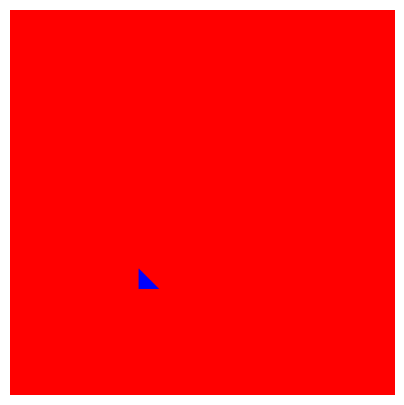

In [45]:
# just getting a random image from df
number = 50 # 39 tri 260 circle  306 square
image_paths = df['image_path']
image_data = PILImage.create(image_paths[number])
Prediction, ClassID, Confidence =learn.predict(image_data)
print(Prediction)
image_data.show()

<Axes: >

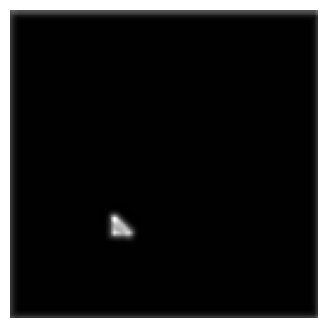

In [38]:
# just getting a random image from df
image_path = 'Node1/image_1.png'
image = PILImage.create(image_path)
image.show()

<Axes: >

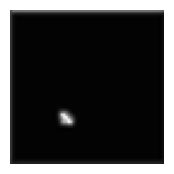

In [39]:
# just getting a random image from df
image_path = 'Node2/image_2.png'
image = PILImage.create(image_path)
image.show()

<Axes: >

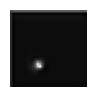

In [40]:
# just getting a random image from df
image_path = 'Node3/image_3.png'
image = PILImage.create(image_path)
image.show()


In [41]:


def create_mosaic(image_folder, output_file, grid_size=(5, 5), thumbnail_size=(100, 100)):

    # List all image files in the folder
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Calculate grid dimensions
    rows, cols = grid_size
    mosaic_width = cols * thumbnail_size[0]
    mosaic_height = rows * thumbnail_size[1]

    # Create a blank canvas
    mosaic = Image.new('RGB', (mosaic_width, mosaic_height), color=(255, 255, 255))

    # Add images to the grid
    for i, image_file in enumerate(image_files[:rows * cols]):
        img = Image.open(image_file)
        img.thumbnail(thumbnail_size)

        # Calculate position
        row = i // cols
        col = i % cols
        x = col * thumbnail_size[0]
        y = row * thumbnail_size[1]

        # Paste image onto the mosaic
        mosaic.paste(img, (x, y))

    # Save the resulting mosaic
    mosaic.save(output_file)
    print(f"Mosaic saved to {output_file}")
    return mosaic

# Usage



In [42]:
#Showimage = False 
Showimage = True 

In [43]:
image_folder = 'Node1'
output_file = 'node1.png'
node1 = create_mosaic(image_folder, output_file, grid_size=(8, 8), thumbnail_size=(128, 128) )
if Showimage == True : 
    node1.show()

Mosaic saved to node1.png


In [35]:
image_folder = 'Node2'
output_file = 'node2.png'
node2 = create_mosaic(image_folder, output_file, grid_size=(8, 16), thumbnail_size=(64, 64))
if Showimage == True : 
    node2.show()

Mosaic saved to node2.png


In [36]:
image_folder = 'Node3'
output_file = 'node3.png'
node3 = create_mosaic(image_folder, output_file, grid_size=(16, 16), thumbnail_size=(32, 32))
if Showimage == True : 
    node3.show()

Mosaic saved to node3.png
